In [217]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel
np.set_printoptions(precision=4, suppress=True)

#### FOCAL MECHANISM INVERSION

Original params:  [359.3064  65.6474  45.8042]


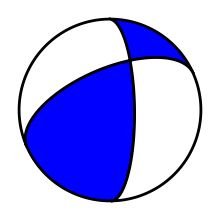

In [218]:
np.random.seed(802)

# generate synthetic data
t = fn.unit_vec(np.random.rand(3))
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
velocities = np.array([5.8000, 3.4600])

In [219]:
importlib.reload(rm)

# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)

model_Ao = radiation_model(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters
config = opt.get_config()
config['k_max'] = 4000

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 100%


In [220]:
params, error, position = radiation_model.get_optimal_parameters(z_threshold=2)
name = 'T' if position == 0 else 'P'

print(f'Constrained axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

Constrained axis: T
Optimal parameters: [41.1082 45.8892  7.3548]
Search error: 0.12891610492416822 degrees


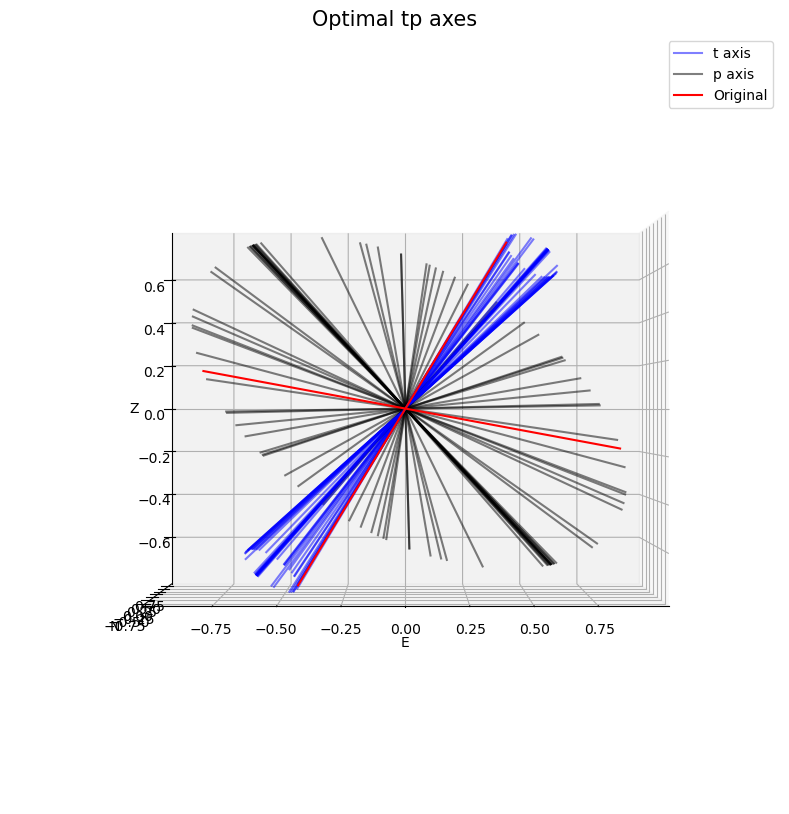

In [221]:
importlib.reload(plots)

plots.tp_axes(radiation_model, azim=-90, elev=00, half=False)

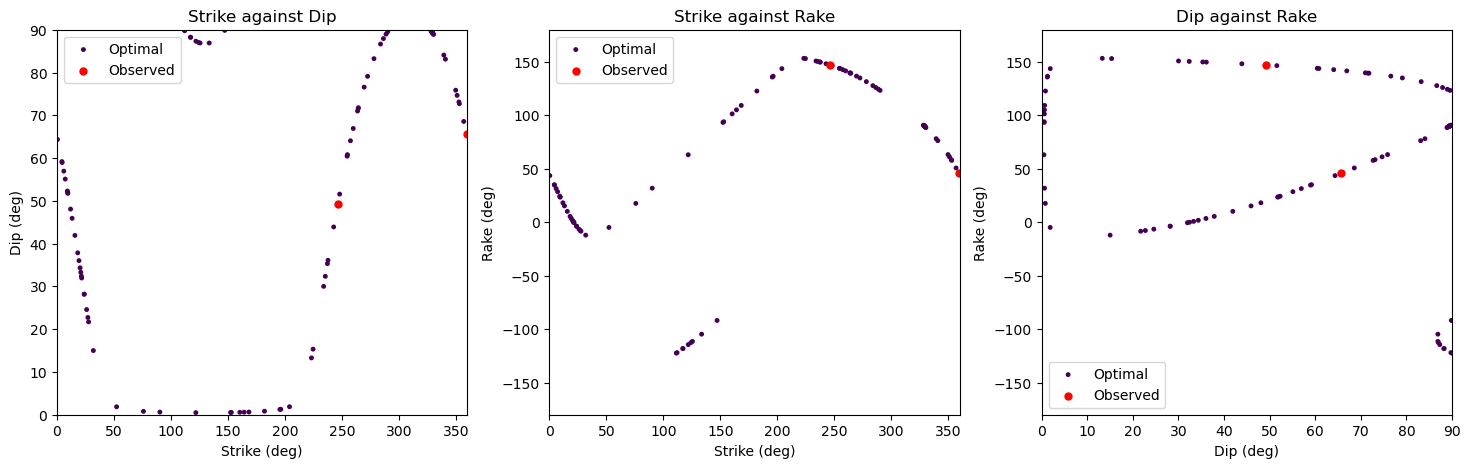

In [222]:
importlib.reload(plots)

plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='viridis')

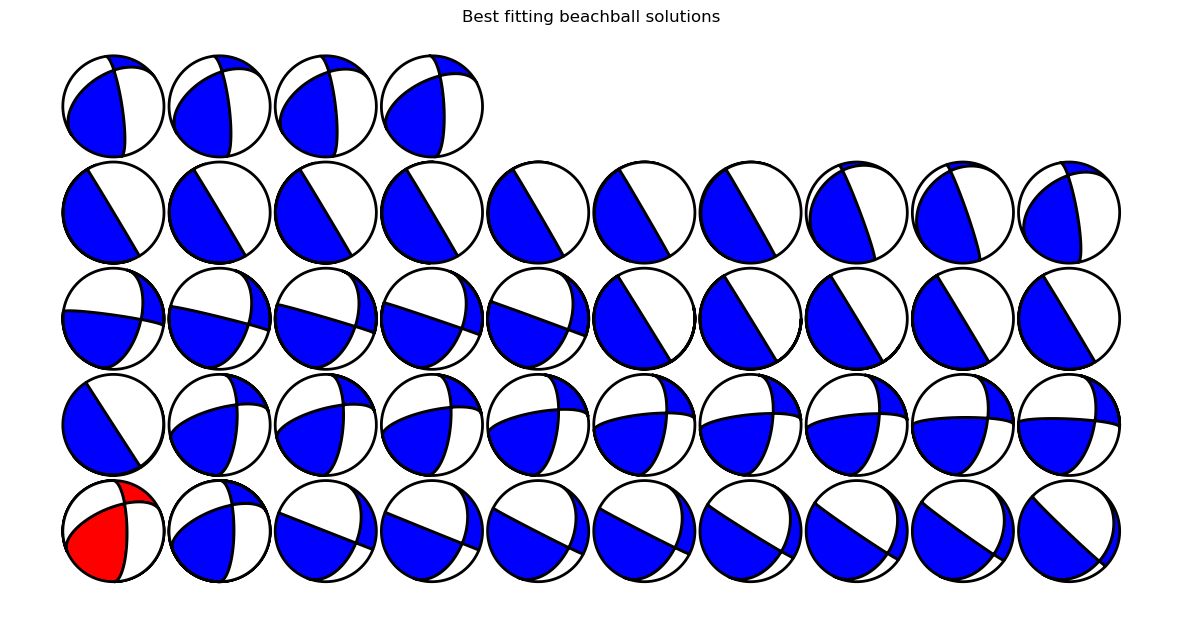

In [223]:
importlib.reload(plots)

plots.beachballs(radiation_model, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(15,10), overlap=False, original=True)

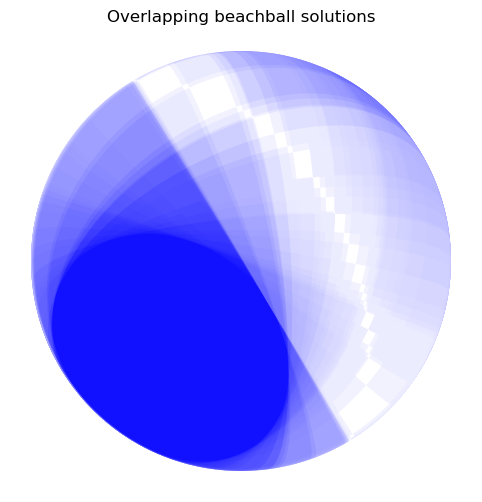

In [224]:
importlib.reload(plots)

plots.beachballs(radiation_model, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(6,6), overlap=True, original=True)

#### UNCERTAINTY QUANTIFICATION

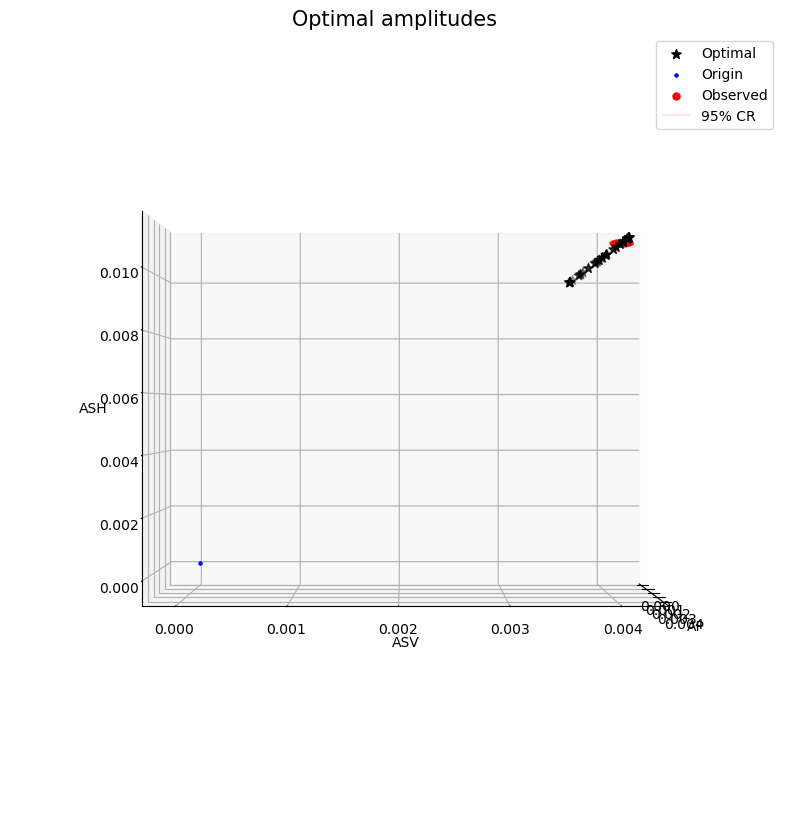

In [225]:
importlib.reload(plots)

radiation_model.reset_grid_amplitudes()
radiation_model.set_grid_amplitudes(7, random=False, fix_params=False)
plots.amplitudes(radiation_model, azim=0, elev=0, s=50, alpha=0.5,
                 iterates=False, grid=False, cross_section=[0,0,0],
                 eps_factor=2e-2, optimal=True, observed=True, cmap='rainbow',
                    uncertainty=True, conf=0.95)

In [226]:
importlib.reload(plots)



<module 'package.plots' from '/home/vay3059/desktop/SURG-Mars/project/package/plots.py'>

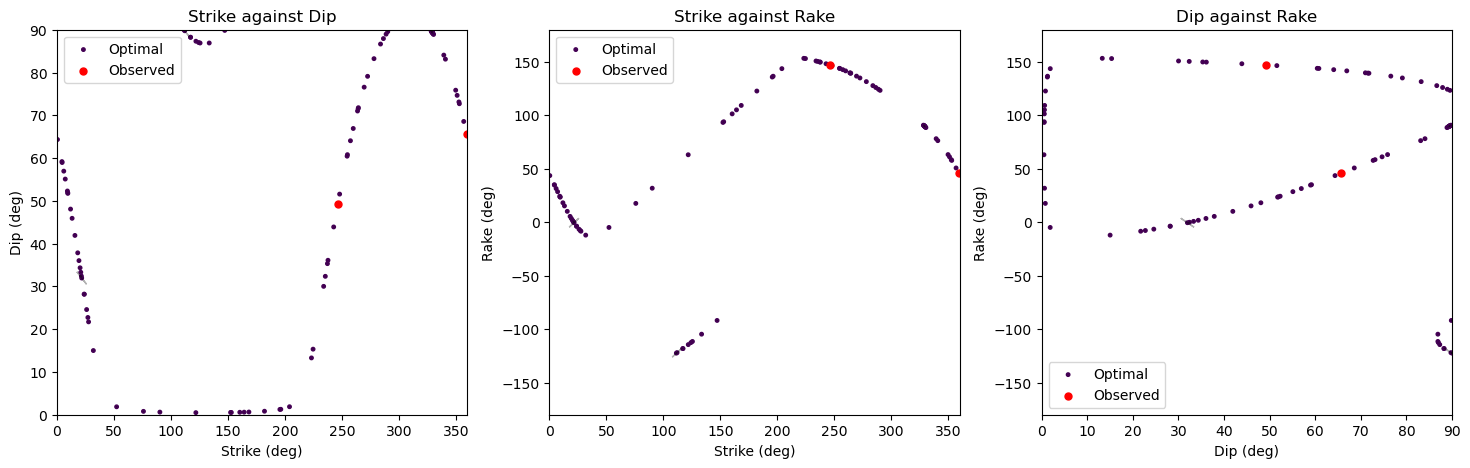

In [ ]:
importlib.reload(plots)

plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='viridis',
                    uncertainty=True, conf=0.95)
# TODO: address observed covariance issue

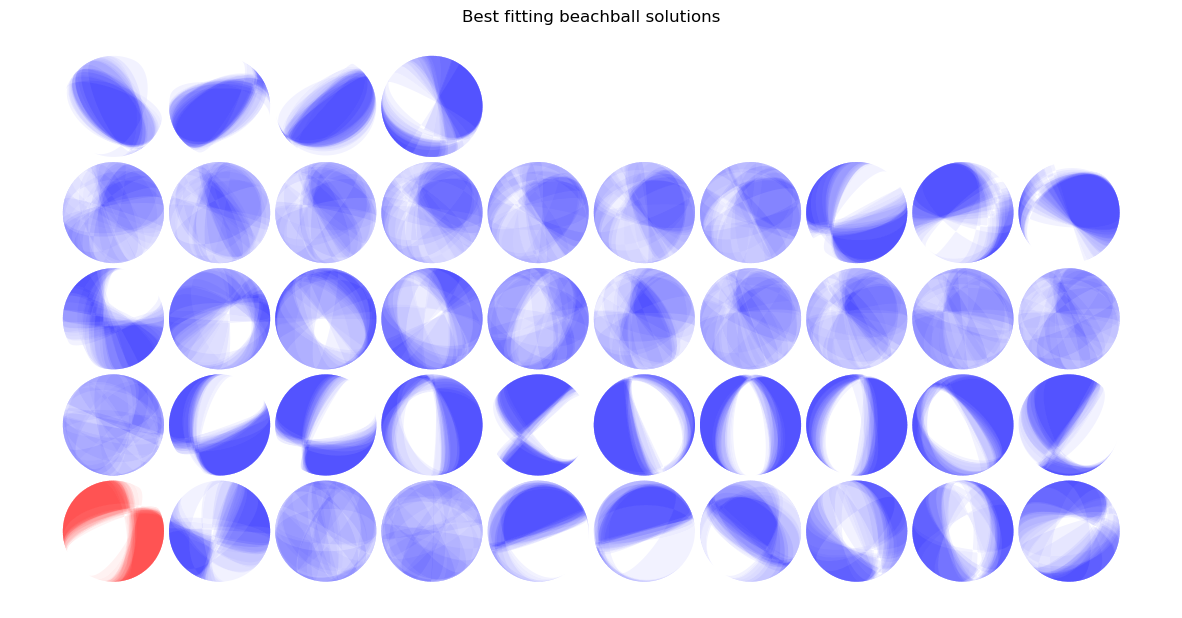

In [228]:
importlib.reload(plots)

plots.beachballs(radiation_model, order_by='strike', width=10,  max_plot=50,
                 original=True, figsize=(15,10), overlap=False, uncertainty=True)

In [ ]:
# test forward propagation of main uncertainty
# edit amplitudes to add a scatter of propagated uncertainty
# now I need this for debugging on the red beachball
# NOTE: i need to check the delta method again for mirror planes
# how is it affected by trigonometric functions?
# what to do about the difference in covariance matrix?
# am I carrying over units correctly?

# BUG: something's flipping the plot of overlapping beachballs!
# reduce numstarts to 1 or 2 and see what happens